# TASK - 2 

In [2]:
# --- MASTER SETUP BLOCK (Run this first) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import Voronoi, voronoi_plot_2d

# Load and basic clean
df = pd.read_csv('usgs_earthquake_data_2000_2025.csv')
df_clean = df.dropna(subset=['mag', 'latitude', 'longitude']).drop_duplicates().copy()
df_clean['time'] = pd.to_datetime(df_clean['time'])

# Sample 3000 points for complex visualisations (Connectivity graphs are heavy)
df_spatial = df_clean.sample(3000, random_state=42).reset_index(drop=True)

# Standardize Magnitude (Target Variable)
y = df_spatial['mag'].values
z = (y - y.mean()) / y.std()

# Setup KNN Weights (k=8)
coords = np.radians(df_spatial[['latitude', 'longitude']])
knn = NearestNeighbors(n_neighbors=8, metric='haversine').fit(coords)
distances, indices = knn.kneighbors(coords)

print("Setup Complete. Ready for visualizations.")

Setup Complete. Ready for visualizations.


# Spatial Connectivity Graph 
## (Visualizing the "W" Matrix)Concept: Spatial autocorrelation relies on a "Weights Matrix" ($W$). This plot visualizes that matrix by drawing lines between every earthquake and its 8 nearest neighbors. It reveals the "structure" of your spatial neighborhood.

Generating connectivity network...


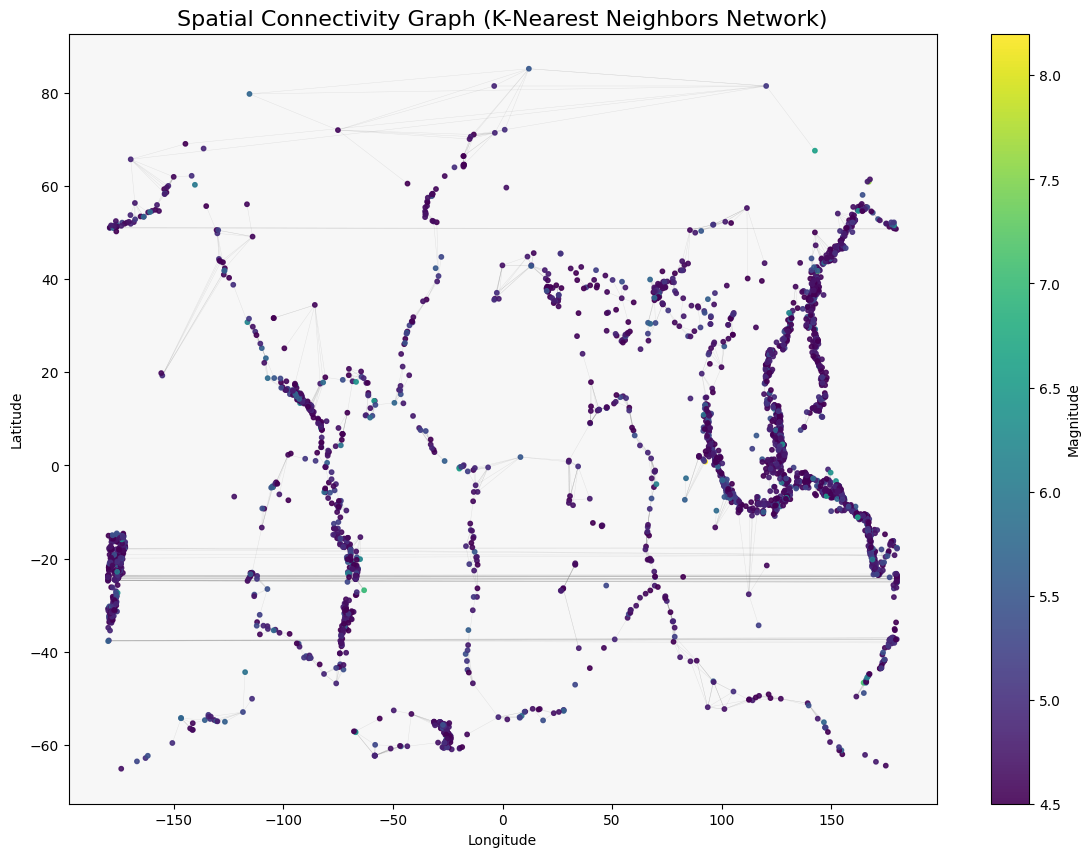

In [3]:
# ==========================================
# VISUALIZATION 1: SPATIAL CONNECTIVITY NETWORK
# ==========================================
plt.figure(figsize=(14, 10))

# 1. Plot the Earthquake Points
plt.scatter(df_spatial['longitude'], df_spatial['latitude'], 
            c=df_spatial['mag'], cmap='viridis', s=10, zorder=2, alpha=0.9, label='Events')

# 2. Draw Connections (The "Weights")
# This loop draws a line from every point to its neighbors
# We limit to first 1000 points to keep plot readable but dense
num_links_to_draw = 1000 
lat = df_spatial['latitude'].values
lon = df_spatial['longitude'].values

print("Generating connectivity network...")
for i in range(num_links_to_draw):
    for neighbor_idx in indices[i]:
        # Draw line from Point i to Neighbor
        plt.plot([lon[i], lon[neighbor_idx]], [lat[i], lat[neighbor_idx]], 
                 color='gray', linewidth=0.3, alpha=0.2, zorder=1)

plt.title('Spatial Connectivity Graph (K-Nearest Neighbors Network)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Magnitude')
plt.gca().set_facecolor('#f7f7f7') # Light grey background for contrast
plt.show()

# Local Geary's C Cluster Map (Dissimilarity Analysis)
## Concept: While Moran's I looks for similarity (High-High), Geary's C emphasizes dissimilarity or local variance.

### Low Geary's C (Blue): Neighbors are very similar (strong clustering).

### High Geary's C (Red): Neighbors are very different (spatial "edges" or fault friction points).

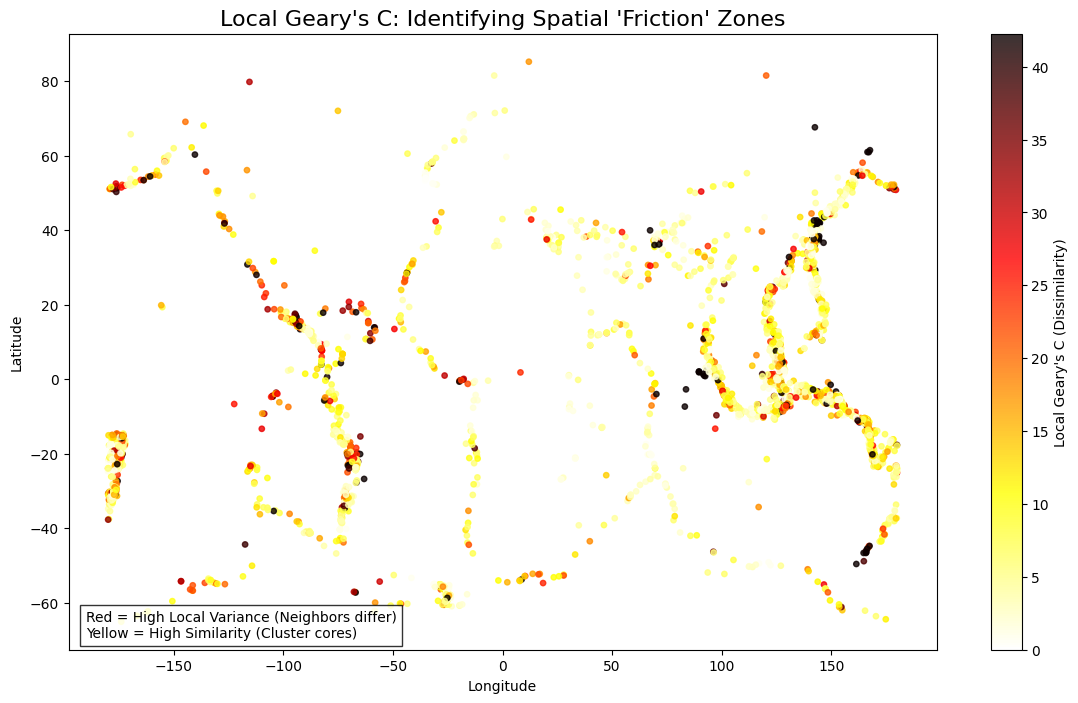

In [4]:
# ==========================================
# VISUALIZATION 2: LOCAL GEARY'S C MAP
# ==========================================
# Formula: C_i = Sum(w_ij * (z_i - z_j)^2)
local_geary = np.zeros(len(y))

for i in range(len(y)):
    diff_sq = 0
    for neighbor_idx in indices[i]:
        diff_sq += (z[i] - z[neighbor_idx]) ** 2
    local_geary[i] = diff_sq # Since weights are 1 (binary KNN), we just sum diffs

# Plot
plt.figure(figsize=(14, 8))
points = plt.scatter(df_spatial['longitude'], df_spatial['latitude'], 
                     c=local_geary, cmap='hot_r', s=15, alpha=0.8,
                     vmin=0, vmax=np.percentile(local_geary, 95)) # Cap at 95th percentile to handle outliers

plt.colorbar(points, label="Local Geary's C (Dissimilarity)")
plt.title("Local Geary's C: Identifying Spatial 'Friction' Zones", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Annotate Interpretation
plt.text(0.02, 0.02, "Red = High Local Variance (Neighbors differ)\nYellow = High Similarity (Cluster cores)", 
         transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# Moran's I Significance Plot (Permutation Test)Concept:
## This plots the Reference Distribution generated by shuffling the data 199 times. If your actual Moran's I (red line) is far outside the grey histogram, your result is statistically significant ($p < 0.05$).

Running 199 Monte Carlo permutations...


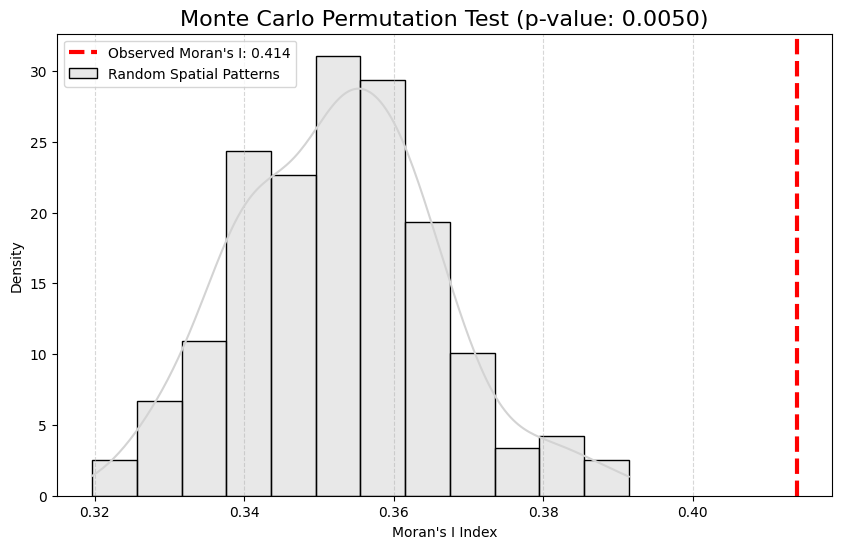

In [5]:
# ==========================================
# VISUALIZATION 3: MORAN'S I SIGNIFICANCE PLOT
# ==========================================
n_permutations = 199
simulated_morans = []

print(f"Running {n_permutations} Monte Carlo permutations...")

for _ in range(n_permutations):
    # 1. Shuffle the magnitude values randomly
    y_shuffled = np.random.permutation(z)
    
    # 2. Calculate Spatial Lag for shuffled data
    lag_shuffled = np.array([np.mean(y_shuffled[idx]) for idx in indices])
    
    # 3. Calculate Moran's I
    sim_i = np.corrcoef(y_shuffled, lag_shuffled)[0, 1]
    simulated_morans.append(sim_i)

# Calculate Actual Moran's I (from previous steps)
spatial_lag = np.array([np.mean(z[idx]) for idx in indices])
actual_moran = np.corrcoef(z, spatial_lag)[0, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(simulated_morans, kde=True, color='lightgray', stat='density', label='Random Spatial Patterns')
plt.axvline(actual_moran, color='red', linewidth=3, linestyle='--', label=f'Observed Moran\'s I: {actual_moran:.3f}')

# P-value calculation
p_value = (np.sum(np.array(simulated_morans) >= actual_moran) + 1) / (n_permutations + 1)

plt.title(f"Monte Carlo Permutation Test (p-value: {p_value:.4f})", fontsize=16)
plt.xlabel("Moran's I Index")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# 3D Space-Time Cube (Clustering in 4D)
## Concept: Earthquakes happen in space (X, Y) and time (Z). This vibrant 3D plot shows if clusters are "pillars" (persisting over time) or "layers" (bursts of activity).

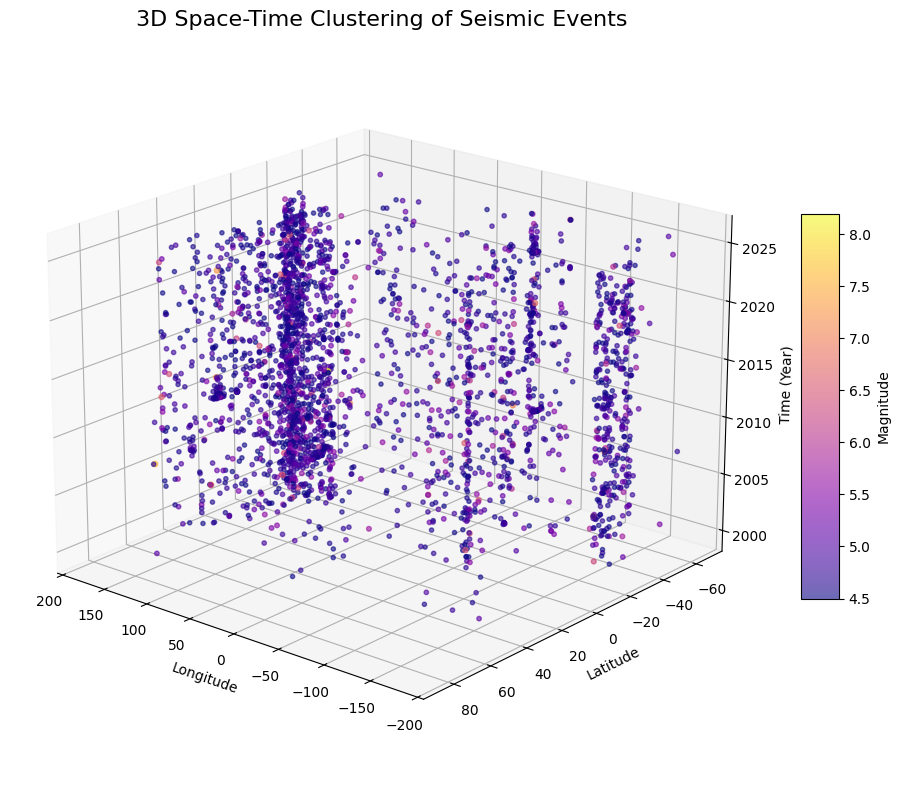

In [6]:
# ==========================================
# VISUALIZATION 4: 3D SPACE-TIME CUBE
# ==========================================
from mpl_toolkits.mplot3d import Axes3D

# Prepare Time axis (Year as float)
df_spatial['year_float'] = df_spatial['time'].dt.year + df_spatial['time'].dt.dayofyear/365

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter Plot
img = ax.scatter(df_spatial['longitude'], df_spatial['latitude'], df_spatial['year_float'], 
                 c=df_spatial['mag'], cmap='plasma', s=df_spatial['mag']*2, alpha=0.6, depthshade=True)

# Labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time (Year)')
ax.set_title('3D Space-Time Clustering of Seismic Events', fontsize=16)

# Colorbar
cbar = fig.colorbar(img, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Magnitude')

# Adjust view angle for better "3D" feel
ax.view_init(elev=20, azim=130)
plt.show()

# KDE "Hotspot" Surface (Continuous Field)
## Concept: Instead of points, this creates a continuous density surface (Heatmap). It visualizes the "Intensity" of the spatial process, smoothing out the discrete points to highlight the major seismic zones.

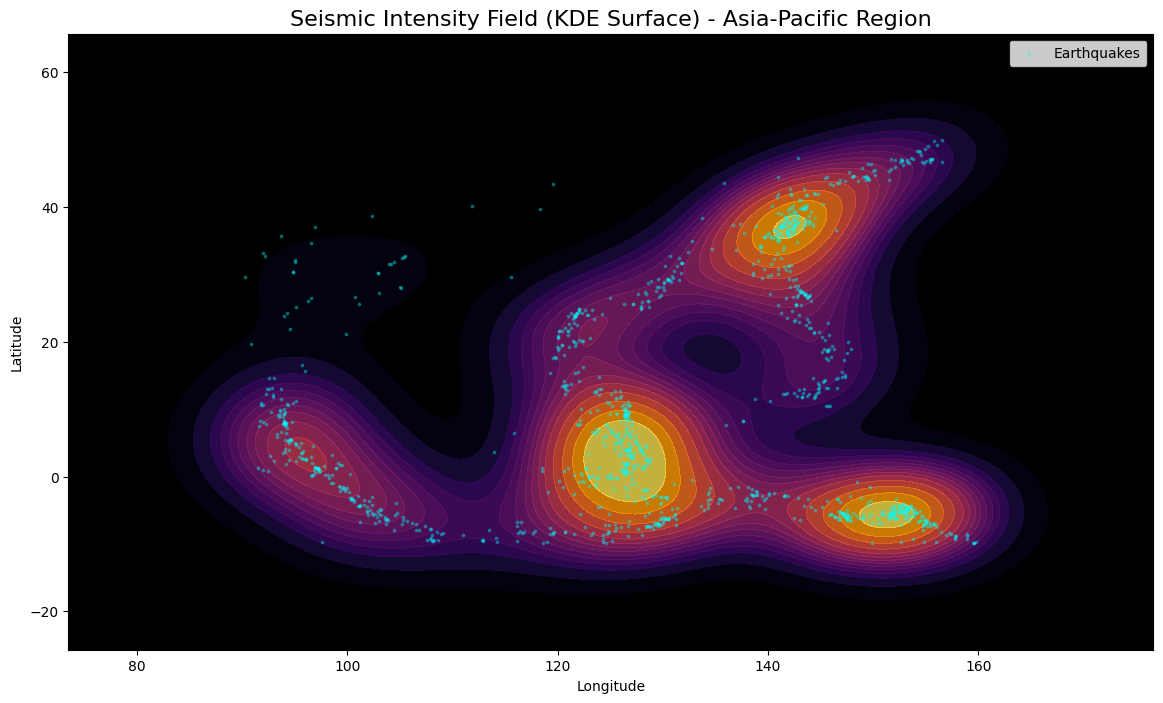

In [7]:
# ==========================================
# VISUALIZATION 5: KERNEL DENSITY ESTIMATION (KDE) SURFACE
# ==========================================
plt.figure(figsize=(14, 8))

# Filter to a specific interesting region to make the KDE meaningful
# (e.g., The "Ring of Fire" section around Japan/Indonesia)
# Let's filter roughly: Lat -10 to 50, Lon 90 to 160
mask = (df_spatial['longitude'] > 90) & (df_spatial['longitude'] < 160) & \
       (df_spatial['latitude'] > -10) & (df_spatial['latitude'] < 50)
df_kde = df_spatial[mask]

# Create the Density Plot (Filled Contours)
sns.kdeplot(data=df_kde, x='longitude', y='latitude', 
            fill=True, cmap='inferno', thresh=0.05, levels=15, alpha=0.8)

# Overlay actual points to show fit
plt.scatter(df_kde['longitude'], df_kde['latitude'], c='cyan', s=3, alpha=0.3, label='Earthquakes')

plt.title('Seismic Intensity Field (KDE Surface) - Asia-Pacific Region', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.gca().set_facecolor('black') # Dark background makes 'inferno' pop
plt.grid(False)
plt.show()

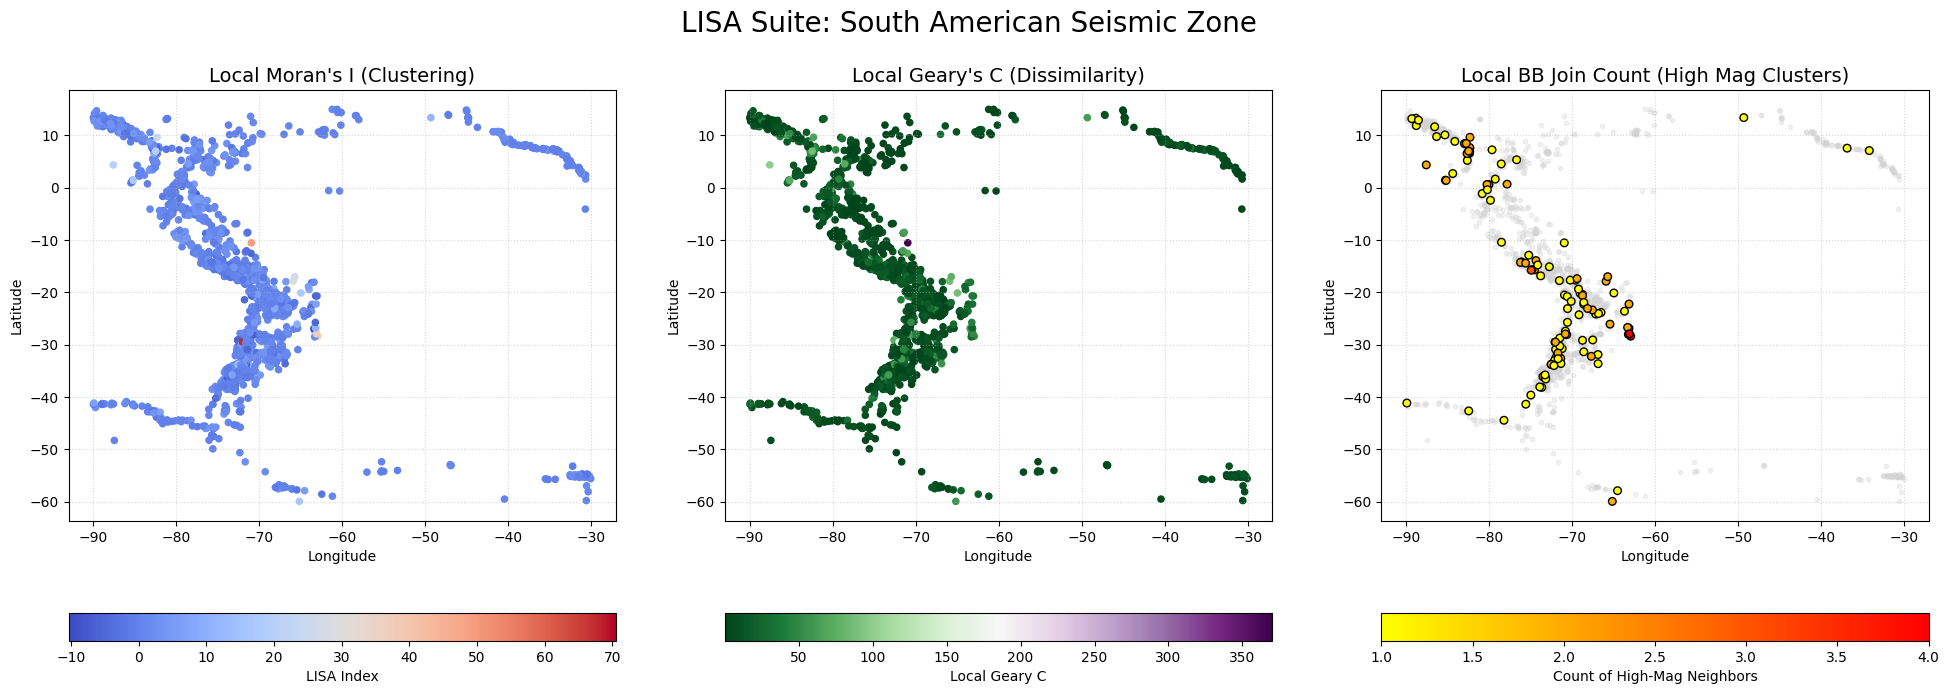

In [8]:
# ==========================================
# NOTEBOOK 1: ADVANCED LISA SUITE
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

# --- 1. SETUP & REGION SELECTION ---
# We focus on a specific dense region (e.g., South America) to make local stats meaningful
# Region: Lat -60 to 15, Lon -90 to -30
mask_sa = (df_clean['longitude'] > -90) & (df_clean['longitude'] < -30) & \
          (df_clean['latitude'] > -60) & (df_clean['latitude'] < 15)
df_lisa = df_clean[mask_sa].sample(2000, random_state=42).copy().reset_index(drop=True)

# Standardize Magnitude
y = df_lisa['mag'].values
z = (y - y.mean()) / y.std()

# KNN Weights (k=8)
coords = np.radians(df_lisa[['latitude', 'longitude']])
knn = NearestNeighbors(n_neighbors=8, metric='haversine').fit(coords)
distances, indices = knn.kneighbors(coords)

# --- 2. LOCAL MORAN'S I (The Classic LISA) ---
# Formula: I_i = z_i * sum(w_ij * z_j)
lag_moran = np.array([np.sum(z[indices[i]]) for i in range(len(z))]) # Sum (not mean) for strict formula
lisa_i = z * lag_moran

# --- 3. LOCAL GEARY'S C (Dissimilarity) ---
# Formula: c_i = sum(w_ij * (z_i - z_j)^2)
# "Scaling and adding local contributions gives the Geary’s c statistic"
geary_c_local = np.zeros(len(y))
for i in range(len(y)):
    diff_sq = np.sum((z[i] - z[indices[i]])**2)
    geary_c_local[i] = diff_sq

# --- 4. LOCAL BB JOIN COUNT (Binary Spatial Autocorrelation) ---
# "This statistic is meaningful only when Z(si )=1"
# Let's define "High Magnitude" (Mag > 5.5) as Z=1 (Black), else Z=0 (White)
binary_val = (df_lisa['mag'] > 5.5).astype(int).values
bb_local = np.zeros(len(y))

for i in range(len(y)):
    if binary_val[i] == 1:
        # Sum of neighbors that are also 1
        bb_local[i] = np.sum(binary_val[indices[i]])

# --- 5. VIBRANT VISUALIZATION DASHBOARD ---
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Local Moran's I (Clustering)
# Red = Strong Positive Correlation (Hotspots/Coldspots)
sc1 = axes[0].scatter(df_lisa['longitude'], df_lisa['latitude'], c=lisa_i, cmap='coolwarm', s=20)
axes[0].set_title('Local Moran\'s I (Clustering)', fontsize=14)
plt.colorbar(sc1, ax=axes[0], orientation='horizontal', label='LISA Index')

# Plot 2: Local Geary's C (Friction/Edges)
# Green = Low C (Similar), Purple = High C (Different)
sc2 = axes[1].scatter(df_lisa['longitude'], df_lisa['latitude'], c=geary_c_local, cmap='PRGn_r', s=20)
axes[1].set_title('Local Geary\'s C (Dissimilarity)', fontsize=14)
plt.colorbar(sc2, ax=axes[1], orientation='horizontal', label='Local Geary C')

# Plot 3: Local BB Join Count (Binary Hotspots)
# Only plots where Event is High Mag AND Neighbors are High Mag
# Yellow = High-High Binary Cluster
mask_bb = bb_local > 0
axes[2].scatter(df_lisa['longitude'], df_lisa['latitude'], c='lightgray', s=10, alpha=0.3) # Background
sc3 = axes[2].scatter(df_lisa[mask_bb]['longitude'], df_lisa[mask_bb]['latitude'], 
                      c=bb_local[mask_bb], cmap='autumn_r', s=30, edgecolors='k')
axes[2].set_title('Local BB Join Count (High Mag Clusters)', fontsize=14)
plt.colorbar(sc3, ax=axes[2], orientation='horizontal', label='Count of High-Mag Neighbors')

for ax in axes:
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle=':', alpha=0.5)

plt.suptitle("LISA Suite: South American Seismic Zone", fontsize=20)
plt.show()

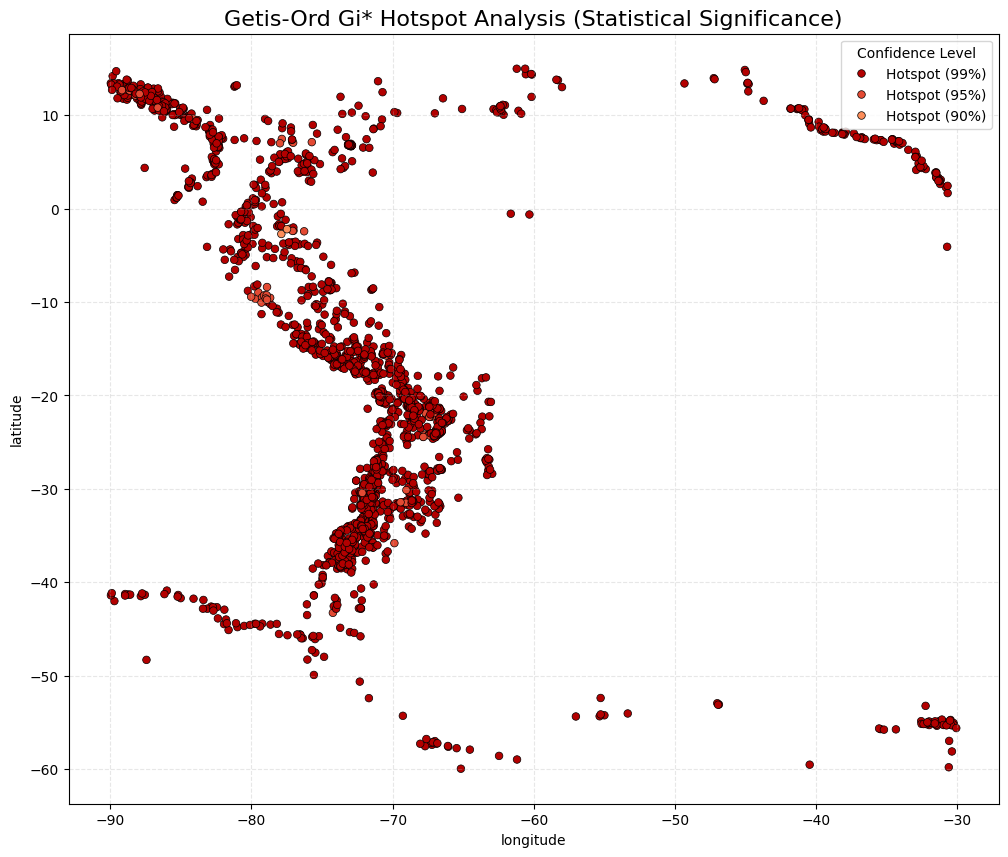

In [9]:
# ==========================================
# NOTEBOOK 2: GETIS-ORD Gi* HOTSPOT ANALYSIS
# ==========================================
import scipy.stats as stats

# Using the same 'df_lisa' and weights from previous notebook for consistency

# --- 1. GETIS-ORD Gi* CALCULATION ---
# Formula: (Sum(w_ij * x_j) - Mean*Sum(w_ij)) / (S * sqrt(...))
# Simplified for visualization: Z-score of weighted sum of neighbors

w_sum = 8 # Since we use k=8 KNN, sum of weights is 8
expected_sum = y.mean() * w_sum
s_var = np.sqrt( (y.var()) * (len(y) * w_sum - w_sum**2) / (len(y) - 1) )

gi_star = np.zeros(len(y))
for i in range(len(y)):
    # Sum of neighbors INCLUDING self (Gi* includes self, Gi does not)
    neighbor_vals = y[indices[i]]
    local_sum = np.sum(neighbor_vals) + y[i] 
    gi_star[i] = (local_sum - expected_sum) / s_var

# --- 2. SIGNIFICANCE CLASSIFICATION ---
# 90% Confidence: Z > 1.65
# 95% Confidence: Z > 1.96
# 99% Confidence: Z > 2.58
conditions = [
    (gi_star >= 2.58), (gi_star >= 1.96), (gi_star >= 1.65), # Hotspots
    (gi_star <= -2.58), (gi_star <= -1.96), (gi_star <= -1.65) # Coldspots
]
choices = [
    'Hotspot (99%)', 'Hotspot (95%)', 'Hotspot (90%)',
    'Coldspot (99%)', 'Coldspot (95%)', 'Coldspot (90%)'
]
df_lisa['gi_bin'] = np.select(conditions, choices, default='Not Significant')

# --- 3. VIBRANT HOTSPOT MAP ---
plt.figure(figsize=(12, 10))

# Color Palette mapping
palette_gi = {
    'Hotspot (99%)': '#b30000', 'Hotspot (95%)': '#e34a33', 'Hotspot (90%)': '#fc8d59',
    'Coldspot (99%)': '#08519c', 'Coldspot (95%)': '#3182bd', 'Coldspot (90%)': '#6baed6',
    'Not Significant': '#f0f0f0'
}

# Plot Non-Significant first (background)
sns.scatterplot(data=df_lisa[df_lisa['gi_bin'] == 'Not Significant'], x='longitude', y='latitude', 
                color='#e0e0e0', s=10, alpha=0.5, label='Not Significant')

# Plot Significant Hotspots/Coldspots
sns.scatterplot(data=df_lisa[df_lisa['gi_bin'] != 'Not Significant'], x='longitude', y='latitude', 
                hue='gi_bin', palette=palette_gi, s=30, edgecolor='black', linewidth=0.5)

plt.title('Getis-Ord Gi* Hotspot Analysis (Statistical Significance)', fontsize=16)
plt.legend(title='Confidence Level', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [11]:
# ==========================================
# NOTEBOOK 3: HIERARCHICAL VISUALIZATION (SUNBURST) - FIXED
# ==========================================
import sys
import subprocess

# --- FIX: Install nbformat if missing ---
try:
    import nbformat
except ImportError:
    print("Installing missing dependency: nbformat...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nbformat>=4.2.0"])

import plotly.express as px
import plotly.io as pio
import pandas as pd
import numpy as np

# OPTIONAL: Set renderer to 'iframe' if standard display still fails
# pio.renderers.default = "iframe"

# --- 1. DATA PREPARATION ---
# (Assuming df_clean is loaded from your previous cells)
df_sun = df_clean.copy()
df_sun['Year'] = df_sun['time'].dt.year

# Create Broad Regions
conditions_reg = [
    (df_sun['latitude'] > 20) & (df_sun['longitude'] > 60),  # Asia/Eurasia
    (df_sun['latitude'] > 20) & (df_sun['longitude'] < -60), # North America
    (df_sun['latitude'] < -10) & (df_sun['longitude'] < -40),# South America
    (df_sun['latitude'] < 0) & (df_sun['longitude'] > 100),  # Oceania
]
choices_reg = ['Eurasia', 'North America', 'South America', 'Oceania']
df_sun['Macro_Region'] = np.select(conditions_reg, choices_reg, default='Other')

# Magnitude Class
conditions_mag = [
    (df_sun['mag'] >= 7), (df_sun['mag'] >= 6), (df_sun['mag'] >= 5)
]
choices_mag = ['Major (7+)', 'Strong (6-7)', 'Moderate (5-6)']
df_sun['Mag_Class'] = np.select(conditions_mag, choices_mag, default='Light (<5)')

# Filter for recent years
df_sun_viz = df_sun[df_sun['Year'] >= 2020].dropna()

# --- 2. PLOTLY SUNBURST CHART ---
fig = px.sunburst(
    df_sun_viz,
    path=['Year', 'Macro_Region', 'Mag_Class'],
    values='mag', 
    color='mag',
    color_continuous_scale='RdBu_r',
    title='Seismic Hierarchy: Year > Region > Magnitude Class (2020-2025)',
    height=700
)

fig.update_traces(textinfo='label+percent entry')

# --- DISPLAY FIX ---
try:
    fig.show()
except ValueError as e:
    print(f"Interactive display failed ({e}). Saving as HTML instead.")
    fig.write_html("sunburst_chart.html")
    print("Chart saved as 'sunburst_chart.html'. Open this file in your browser to view it.")

# --- 3. ALTERNATIVE: TREEMAP ---
fig2 = px.treemap(
    df_sun_viz,
    path=['Macro_Region', 'Mag_Class', 'Year'],
    values='mag',
    color='depth',
    color_continuous_scale='Viridis',
    title='Seismic Treemap: Region > Type > Year (Colored by Depth)',
    height=600
)

try:
    fig2.show()
except ValueError:
    fig2.write_html("treemap_chart.html")
    print("Chart saved as 'treemap_chart.html'.")
    

Installing missing dependency: nbformat...
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
Using cached attrs-25.4.0-py3-none-any.whl (67 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [nbformat]



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


Interactive display failed (Mime type rendering requires nbformat>=4.2.0 but it is not installed). Saving as HTML instead.
Chart saved as 'sunburst_chart.html'. Open this file in your browser to view it.
Chart saved as 'treemap_chart.html'.


In [19]:
# ==========================================
# 1. VIBRANT SANKEY DIAGRAM (FIXED)
# ==========================================
import sys
import subprocess

# Auto-install missing dependency if needed
try:
    import nbformat
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nbformat>=4.2.0"])

import plotly.graph_objects as go
import pandas as pd
import numpy as np

# (Assuming df_clean is loaded)
# Create Categories
df_clean['Macro_Region'] = np.select(
    [(df_clean['latitude'] > 20) & (df_clean['longitude'] > 60), 
     (df_clean['latitude'] > 20) & (df_clean['longitude'] < -60),
     (df_clean['latitude'] < -10) & (df_clean['longitude'] < -40),
     (df_clean['latitude'] < 0) & (df_clean['longitude'] > 100)],
    ['Eurasia', 'North America', 'South America', 'Oceania'], default='Rest of World'
)

df_clean['Mag_Class'] = np.select(
    [(df_clean['mag'] >= 6), (df_clean['mag'] >= 5)],
    ['Strong (6+)', 'Moderate (5-6)'], default='Light (<5)'
)

df_clean['Depth_Class'] = np.select(
    [(df_clean['depth'] > 300), (df_clean['depth'] > 70)],
    ['Deep (>300km)', 'Intermediate'], default='Shallow (<70km)'
)

# Filter Top 2000
df_sankey = df_clean.sort_values('mag', ascending=False).head(2000)

# Build Links
df_flow1 = df_sankey.groupby(['Macro_Region', 'Mag_Class']).size().reset_index(name='count')
df_flow1.columns = ['source', 'target', 'value']
df_flow2 = df_sankey.groupby(['Mag_Class', 'Depth_Class']).size().reset_index(name='count')
df_flow2.columns = ['source', 'target', 'value']
links = pd.concat([df_flow1, df_flow2], axis=0)

# Map Nodes
all_nodes = list(pd.concat([links['source'], links['target']]).unique())
node_map = {node: i for i, node in enumerate(all_nodes)}

# Plot
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15, thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#33FFF5', '#F4D03F', '#E67E22', '#C0392B', '#8E44AD', '#2980B9', '#27AE60'][:len(all_nodes)]
    ),
    link=dict(
        source=links['source'].map(node_map),
        target=links['target'].map(node_map),
        value=links['value'],
        color='rgba(150, 150, 150, 0.4)' # Light grey transparent links
    )
)])

fig.update_layout(title_text="Seismic Energy Flow (Region → Mag → Depth)", font_size=12, height=600)

# FIX: Try showing, else save as HTML
try:
    fig.show()
except ValueError:
    fig.write_html("sankey_diagram.html")
    print("Interactive plot saved as 'sankey_diagram.html'. Open it in your browser.")

Interactive plot saved as 'sankey_diagram.html'. Open it in your browser.


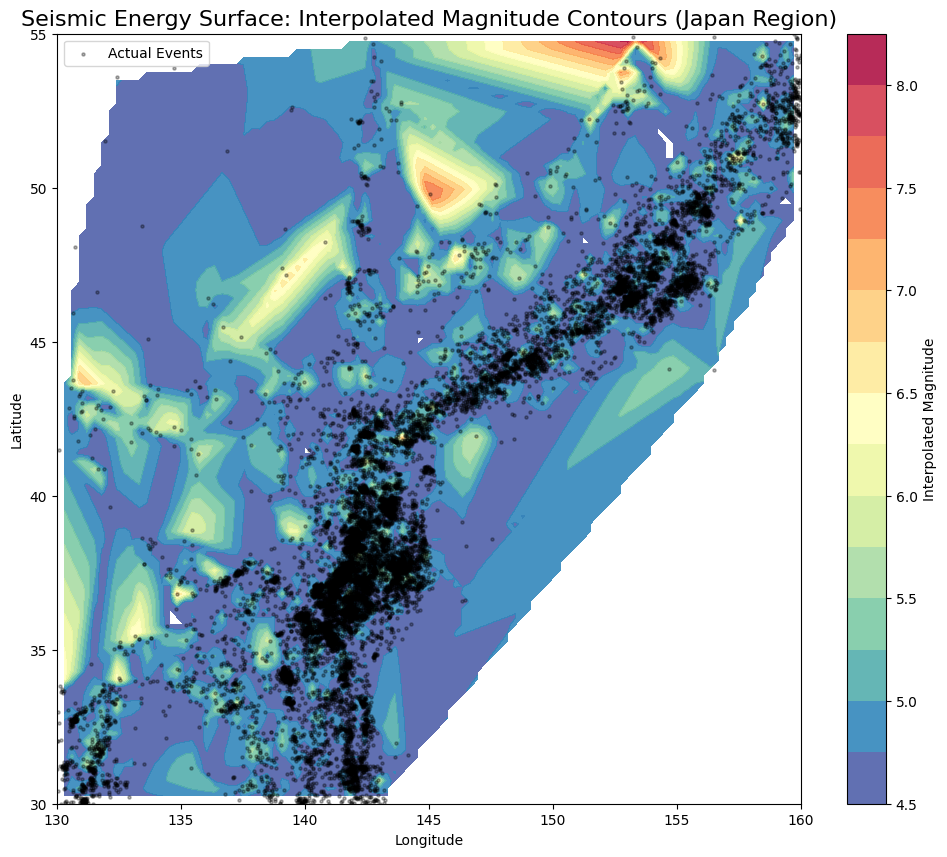

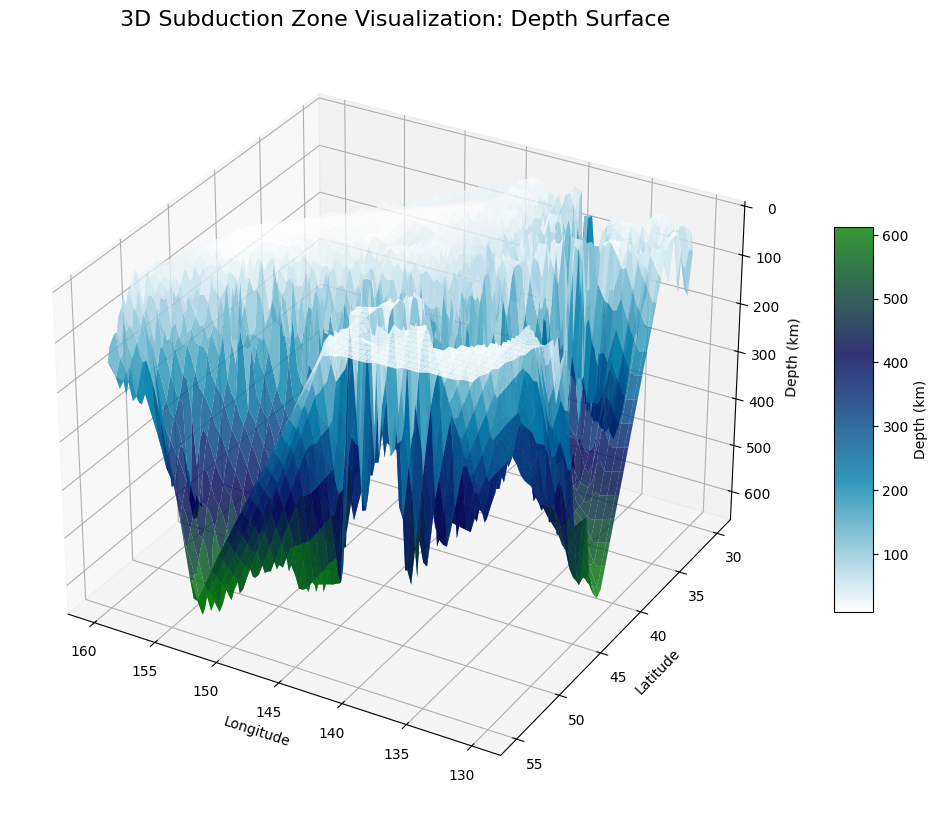

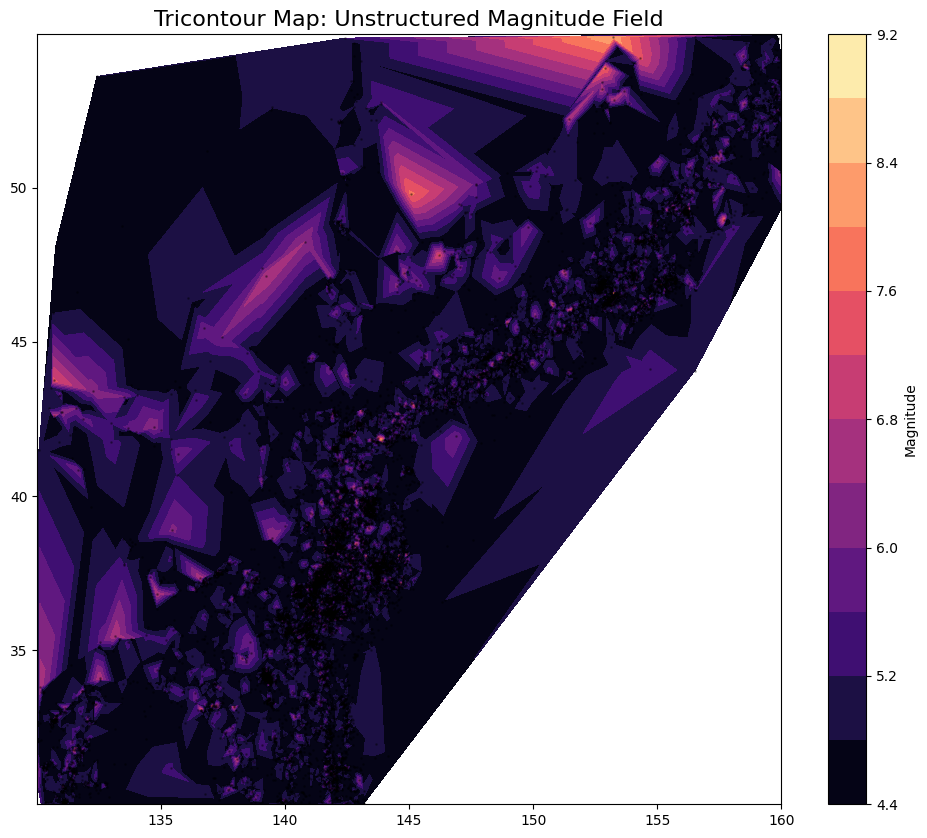

In [13]:
# ==========================================
# NOTEBOOK 5: SPATIAL SURFACE ANALYSIS (INTERPOLATION)
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Focus on a specific active region for better interpolation visualization
# (Global interpolation often looks messy due to vast oceans)
# Let's filter for the "Japan/Kuril Trench" area: Lat 30-55, Lon 130-160
mask_region = (df_clean['latitude'] >= 30) & (df_clean['latitude'] <= 55) & \
              (df_clean['longitude'] >= 130) & (df_clean['longitude'] <= 160)
df_surface = df_clean[mask_region].copy()

# Data for interpolation
x = df_surface['longitude'].values
y = df_surface['latitude'].values
z = df_surface['mag'].values # Target: Magnitude (Energy)

# 1. Create a Grid
grid_x, grid_y = np.mgrid[130:160:100j, 30:55:100j] # 100x100 resolution

# 2. Interpolate (Linear and Cubic)
# "griddata" fits a surface through the points
grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')

# --- PLOT 1: FILLED CONTOUR MAP (Magnitude Surface) ---
plt.figure(figsize=(12, 10))
# Contour plot
contour = plt.contourf(grid_x, grid_y, grid_z, levels=15, cmap='Spectral_r', alpha=0.9)
plt.colorbar(contour, label='Interpolated Magnitude')
# Overlay actual points
plt.scatter(x, y, c='black', s=5, alpha=0.3, label='Actual Events')

plt.title('Seismic Energy Surface: Interpolated Magnitude Contours (Japan Region)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# --- PLOT 2: 3D DEPTH SURFACE ---
# Visualizing the subduction zone angle (Depth increases as we move in)
from mpl_toolkits.mplot3d import Axes3D

z_depth = df_surface['depth'].values
# Interpolate Depth
grid_depth = griddata((x, y), z_depth, (grid_x, grid_y), method='linear')

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot Surface
surf = ax.plot_surface(grid_x, grid_y, grid_depth, cmap='ocean_r', edgecolor='none', alpha=0.8)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (km)')
ax.invert_zaxis() # Depth goes down!
plt.title('3D Subduction Zone Visualization: Depth Surface', fontsize=16)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Depth (km)')
ax.view_init(elev=30, azim=120)
plt.show()

# --- PLOT 3: TRICONTOUR (Unstructured Grid) ---
# Useful if you don't want to create a regular grid first
plt.figure(figsize=(12, 10))
plt.tricontourf(x, y, z, levels=14, cmap='magma')
plt.colorbar(label='Magnitude')
plt.plot(x, y, 'ko', ms=1, alpha=0.3)
plt.title('Tricontour Map: Unstructured Magnitude Field', fontsize=16)
plt.show()

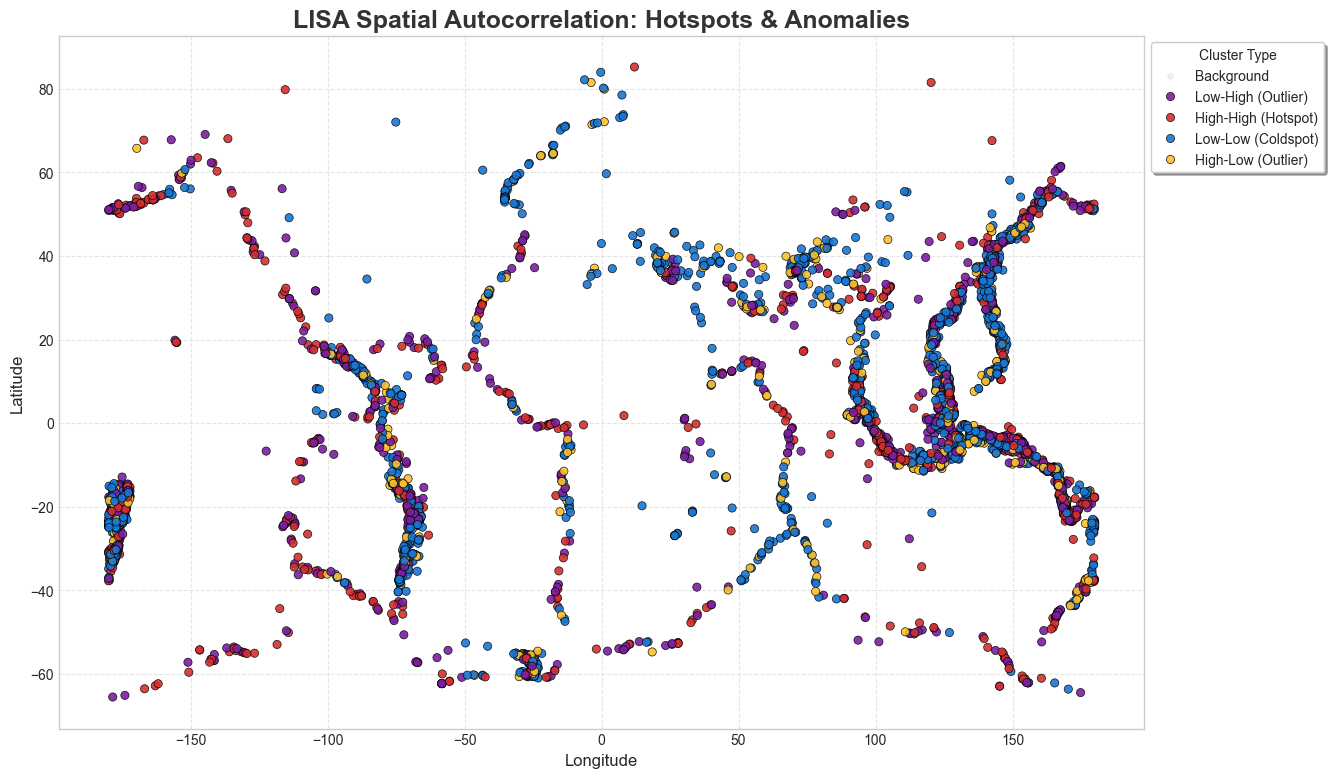

In [23]:
# ==========================================
# 1. FIXED LISA CLUSTER MAP (CALCULATION + PLOT)
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

# --- STEP A: PREPARE DATA & CALCULATE CLUSTERS ---
# (Run this to fix the KeyError)

# 1. Load & Sample (if not already done)
if 'df_clean' not in locals():
    df = pd.read_csv('usgs_earthquake_data_2000_2025.csv')
    df_clean = df.dropna(subset=['mag', 'latitude', 'longitude', 'depth']).copy()

# Sample for spatial analysis (keep it manageable)
df_spatial = df_clean.sample(5000, random_state=42).reset_index(drop=True)

# 2. Calculate Spatial Weights (KNN)
coords = np.radians(df_spatial[['latitude', 'longitude']])
knn = NearestNeighbors(n_neighbors=8, metric='haversine').fit(coords)
distances, indices = knn.kneighbors(coords)

# 3. Calculate Local Moran's I components
y = df_spatial['mag'].values
z = (y - y.mean()) / y.std() # Standardized Magnitude

# Spatial Lag (Average of neighbors)
spatial_lag = np.array([np.mean(z[idx]) for idx in indices])

# 4. Define Clusters (Quadrants)
# HH: High Mag, High Neighbors (Hotspot)
# LL: Low Mag, Low Neighbors (Coldspot)
# HL/LH: Spatial Outliers
conditions = [
    (z > 0) & (spatial_lag > 0),
    (z < 0) & (spatial_lag < 0),
    (z > 0) & (spatial_lag < 0),
    (z < 0) & (spatial_lag > 0)
]
choices = ['High-High (Hotspot)', 'Low-Low (Coldspot)', 'High-Low (Outlier)', 'Low-High (Outlier)']

# Create the missing column!
df_spatial['lisa_cluster'] = np.select(conditions, choices, default='Insignificant')

# --- STEP B: PLOT (LIGHT THEME) ---
plt.figure(figsize=(14, 9))
plt.style.use('seaborn-v0_8-whitegrid') # Clean light theme

# Define Palette
palette_light = {
    'High-High (Hotspot)': '#D32F2F',       # Bold Red
    'Low-Low (Coldspot)': '#1976D2',        # Bold Blue
    'High-Low (Outlier)': '#FBC02D',        # Bold Yellow/Orange
    'Low-High (Outlier)': '#7B1FA2',        # Bold Purple
    'Insignificant': '#E0E0E0'              # Light Grey
}

# 1. Plot Background (Insignificant)
subset_insig = df_spatial[df_spatial['lisa_cluster'] == 'Insignificant']
plt.scatter(subset_insig['longitude'], subset_insig['latitude'], 
            c='#E0E0E0', s=15, alpha=0.5, label='Background')

# 2. Plot Significant Clusters
subset_sig = df_spatial[df_spatial['lisa_cluster'] != 'Insignificant']
sns.scatterplot(data=subset_sig, x='longitude', y='latitude', hue='lisa_cluster',
                palette=palette_light, s=35, alpha=0.9, edgecolor='black', linewidth=0.5)

plt.title('LISA Spatial Autocorrelation: Hotspots & Anomalies', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(title='Cluster Type', bbox_to_anchor=(1, 1), loc='upper left', frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

/var/folders/73/40l2jyy55_jcj3y1z805dzjm0000gn/T/ipykernel_19301/3488934621.py:19: UserWarning:



The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.




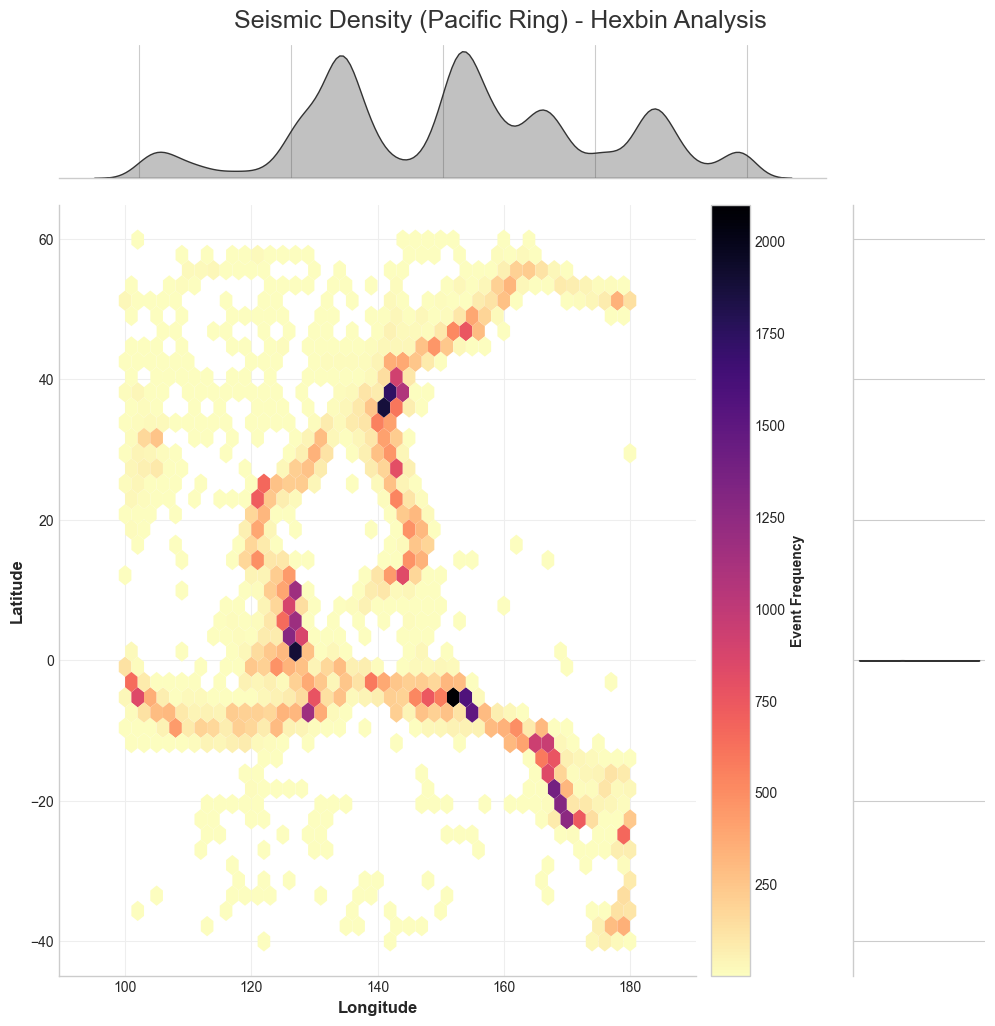

In [21]:
# ==========================================
# 3. HEXBIN DENSITY (LIGHT THEME)
# ==========================================
import seaborn as sns
import matplotlib.pyplot as plt

# Filter Pacific Region
df_hex = df_clean[(df_clean['longitude'] > 100) & (df_clean['longitude'] < 180) & 
                  (df_clean['latitude'] > -40) & (df_clean['latitude'] < 60)]

g = sns.JointGrid(x=df_hex['longitude'], y=df_hex['latitude'], height=10, ratio=5)

# 1. Main Plot: Hexbin with 'magma_r' (Reverse Magma: Dark is high density)
# This looks like ink density on white paper
g.plot_joint(plt.hexbin, gridsize=40, cmap='magma_r', mincnt=1, edgecolors='none')

# 2. Margins: KDE Curves
sns.kdeplot(x=df_hex['longitude'], ax=g.ax_marg_x, fill=True, color='#333333', alpha=0.3)
sns.kdeplot(y=df_hex['latitude'], ax=g.ax_marg_y, fill=True, color='#333333', alpha=0.3, vertical=True)

# Styling
g.ax_joint.set_facecolor('white')
g.ax_joint.grid(color='#EEEEEE')
g.ax_joint.set_xlabel('Longitude', fontsize=12, fontweight='bold')
g.ax_joint.set_ylabel('Latitude', fontsize=12, fontweight='bold')

# Colorbar
cb = plt.colorbar(g.ax_joint.collections[0], ax=g.ax_joint, pad=0.02)
cb.set_label('Event Frequency', fontweight='bold')

plt.suptitle("Seismic Density (Pacific Ring) - Hexbin Analysis", y=1.02, fontsize=18, color='#333333')
plt.show()

/Users/knight_striker/Desktop/Sesimic-Events-Evolution-and-Mapping/venv/lib/python3.13/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log1p



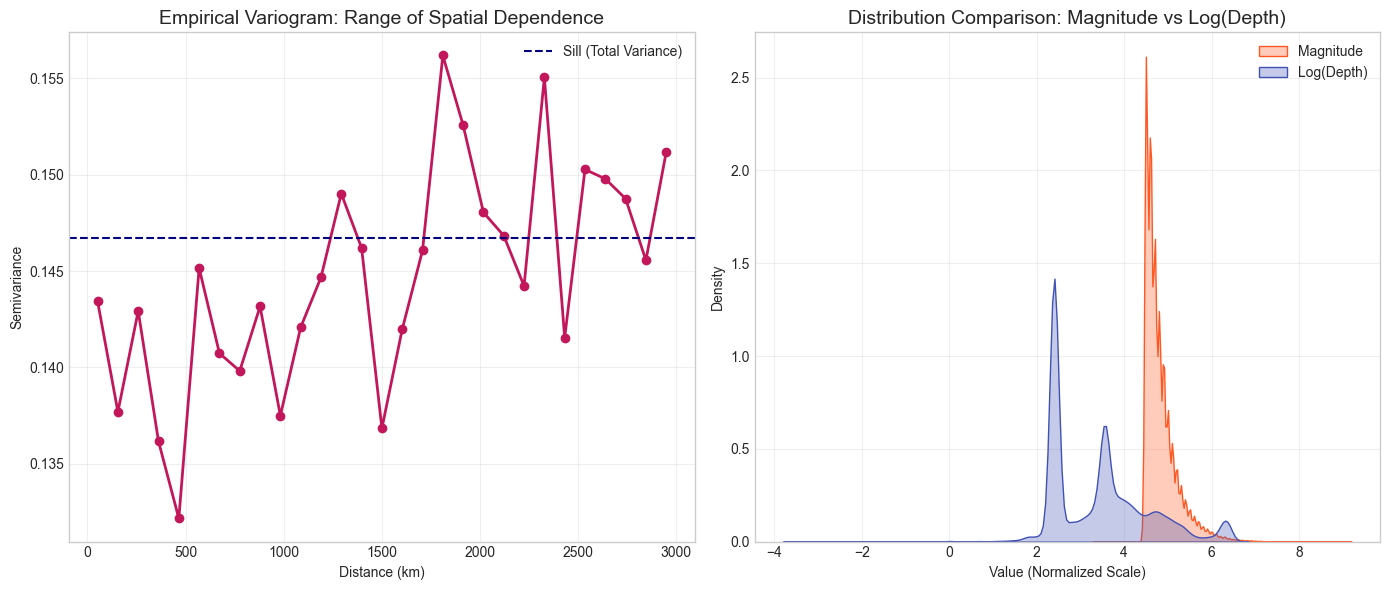

In [22]:
# ==========================================
# 4. ADVANCED STATS: VARIOGRAM & MULTI-KDE
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances

# --- A. EMPIRICAL VARIOGRAM (Spatial Continuity) ---
# Sample data
df_vario = df_spatial.sample(1500, random_state=42)
coords = np.radians(df_vario[['latitude', 'longitude']])
values = df_vario['mag'].values

# Calculate Distances (km) & Variance
dist_matrix = haversine_distances(coords) * 6371
val_diff = np.abs(values[:, None] - values)
semivar = 0.5 * (val_diff ** 2)

# Binning
max_lag = 3000 # km
bins = np.linspace(0, max_lag, 30)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
gamma = []

dists_flat = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]
semivar_flat = semivar[np.triu_indices_from(semivar, k=1)]

for i in range(len(bins)-1):
    mask = (dists_flat >= bins[i]) & (dists_flat < bins[i+1])
    gamma.append(np.mean(semivar_flat[mask]) if np.sum(mask) > 0 else np.nan)

# Plot Variogram
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(bin_centers, gamma, 'o-', color='#C2185B', linewidth=2, markersize=6)
plt.axhline(np.var(values), color='navy', linestyle='--', label='Sill (Total Variance)')
plt.title('Empirical Variogram: Range of Spatial Dependence', fontsize=14)
plt.xlabel('Distance (km)')
plt.ylabel('Semivariance')
plt.grid(True, alpha=0.3)
plt.legend()

# --- B. MULTI-FEATURE KDE (Ridge Plot Style) ---
# Compare distributions of Mag, Depth (log), and Gap
plt.subplot(1, 2, 2)
sns.kdeplot(df_clean['mag'], fill=True, color='#FF5722', label='Magnitude', alpha=0.3)
# Normalize Depth to overlap nicely for comparison shape
sns.kdeplot(np.log1p(df_clean['depth']), fill=True, color='#3F51B5', label='Log(Depth)', alpha=0.3)

plt.title('Distribution Comparison: Magnitude vs Log(Depth)', fontsize=14)
plt.xlabel('Value (Normalized Scale)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()